In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf

In [2]:
## Extracting stock data using yfinance
df = yf.download("INR=X", start="2010-01-01", end="2023-10-01")

C:\Users\ansul\AppData\Local\Temp\ipykernel_10368\668326908.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INR=X", start="2010-01-01", end="2023-10-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,INR=X,INR=X,INR=X,INR=X,INR=X
Date,,,,,
2010-01-01,46.610001,46.645000,46.400002,46.400002,0
2010-01-04,46.287998,46.610001,46.223000,46.610001,0
2010-01-05,46.119999,46.287998,46.088001,46.287998,0
2010-01-06,45.720001,46.180000,45.700001,46.147999,0
2010-01-07,45.688000,45.877998,45.557999,45.737999,0


In [6]:
df.columns

MultiIndex([( 'Close', 'INR=X'),
            (  'High', 'INR=X'),
            (   'Low', 'INR=X'),
            (  'Open', 'INR=X'),
            ('Volume', 'INR=X')],
           names=['Price', 'Ticker'])

### Exploratory data analysis

C:\Users\ansul\AppData\Local\Temp\ipykernel_10368\1964124317.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_close_yearly = df[('Close', 'INR=X')].resample('Y').mean()


<Axes: title={'center': 'Yearly Average Close Price for INR-X'}, xlabel='Year', ylabel='Average Close Price ($)'>

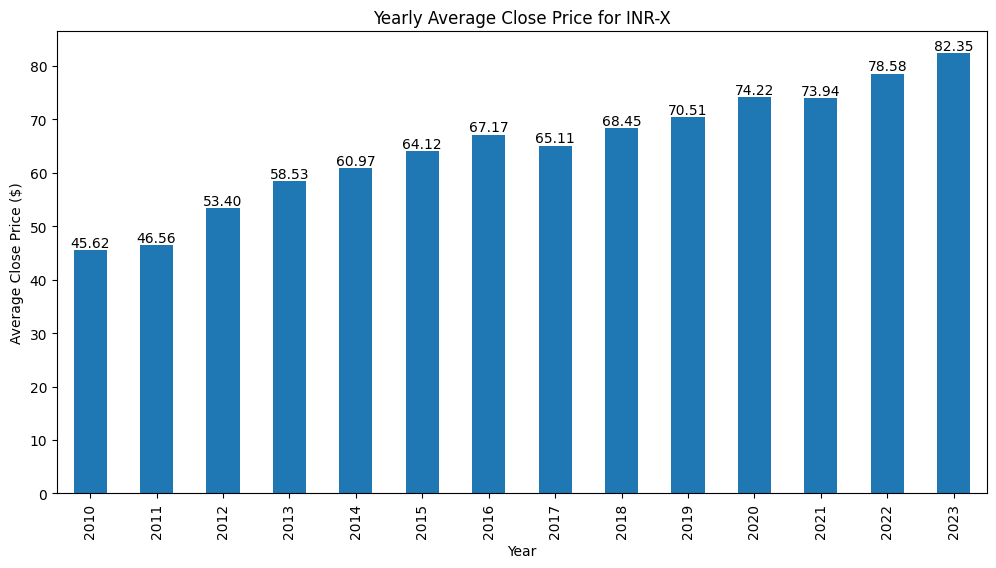

In [9]:
# Resample the DataFrame to yearly frequency and calculate the mean of the 'Close' price
avg_close_yearly = df[('Close', 'INR=X')].resample('Y').mean()

# Plot the yearly average close price
ax = avg_close_yearly.plot(kind='bar', figsize=(12, 6), title='Yearly Average Close Price for INR-X', ylabel='Average Close Price ($)', xlabel='Year')

# Annotate values on top of bars
for i, v in enumerate(avg_close_yearly.values):
    ax.text(i, v, f"{v:.2f}", ha='center', va='bottom')
avg_close_yearly.index = avg_close_yearly.index.year

# Plot the yearly average close price
avg_close_yearly.plot(kind='bar', figsize=(12, 6), title='Yearly Average Close Price for INR-X', ylabel='Average Close Price ($)', xlabel='Year',)

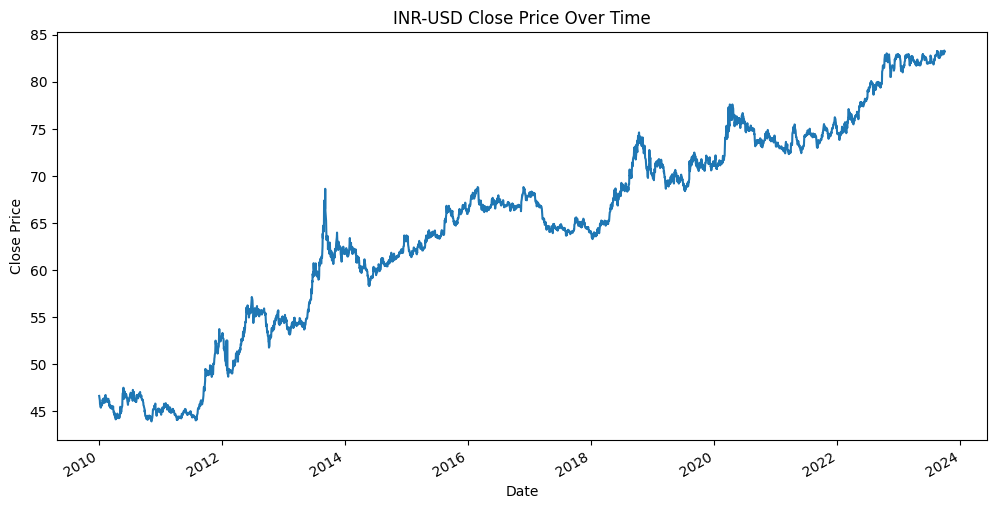

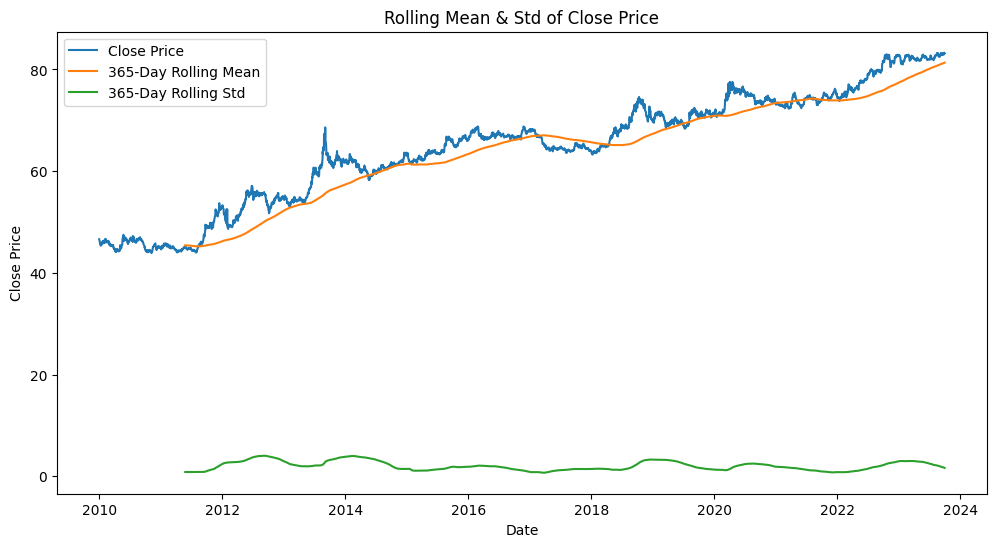

C:\Users\ansul\AppData\Local\Temp\ipykernel_10368\203718265.py:24: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_return = df[('Close', 'INR=X')].resample('Y').ffill().pct_change() * 100


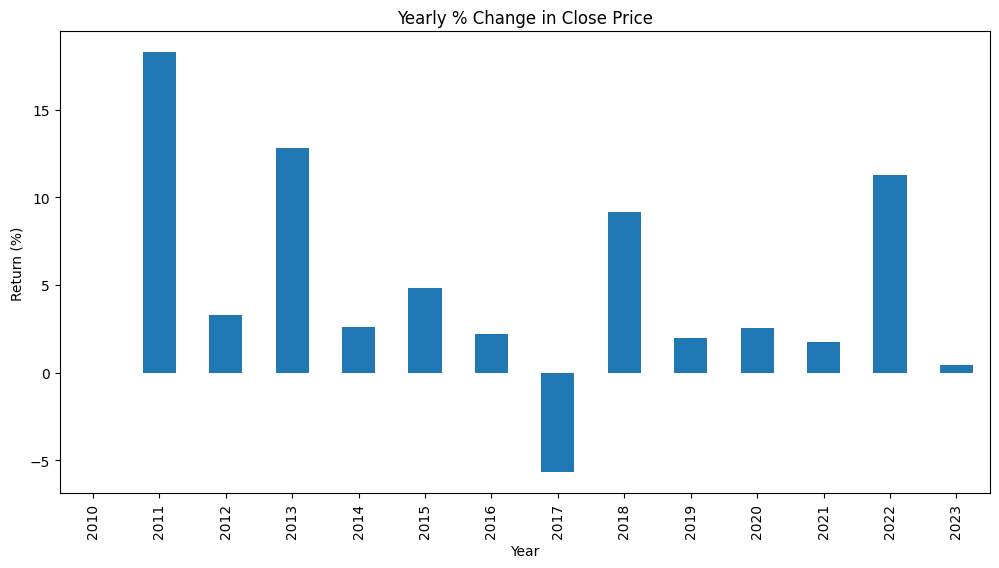

count    3581.000000
mean       64.655760
std        10.738209
min        43.900002
25%        57.007999
50%        66.084999
75%        73.108299
max        83.298698
Name: (Close, INR=X), dtype: float64

In [10]:
# Time Series EDA for INR-USD Forex Data

# 1. Plot the full Close price time series
df[('Close', 'INR=X')].plot(figsize=(12, 6), title='INR-USD Close Price Over Time', ylabel='Close Price', xlabel='Date')

# 2. Plot rolling mean and rolling std
window = 365  # 1 year window
rolling_mean = df[('Close', 'INR=X')].rolling(window=window).mean()
rolling_std = df[('Close', 'INR=X')].rolling(window=window).std()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df[('Close', 'INR=X')], label='Close Price')
plt.plot(rolling_mean, label=f'{window}-Day Rolling Mean')
plt.plot(rolling_std, label=f'{window}-Day Rolling Std')
plt.title('Rolling Mean & Std of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 3. Plot yearly returns
yearly_return = df[('Close', 'INR=X')].resample('Y').ffill().pct_change() * 100
yearly_return.index = yearly_return.index.year
yearly_return.plot(kind='bar', figsize=(12, 6), title='Yearly % Change in Close Price', ylabel='Return (%)', xlabel='Year')
plt.show()

# 4. Show summary statistics
df[('Close', 'INR=X')].describe()

### Preparing Data for LSTM

In [16]:
df = df.reset_index()

In [17]:
df_close = df[('Close', 'INR=X')].copy()

In [22]:
## Normalizing the close price data as LSTM are sesnsitive to the scale of input data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))
print(df_close)

[[0.06878398]
 [0.06061106]
 [0.05634698]
 ...
 [1.        ]
 [0.99807109]
 [0.99731723]]


In [25]:
##splitting data into training and testing set 
training_size=int(len(df_close)*0.80)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]

In [26]:
training_size,test_size

(2864, 717)

In [ ]:
## Converting forex data into input suitable for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [36]:
X_train, y_train = create_dataset(train_data, time_step = 100)
X_test, y_test = create_dataset(test_data, time_step = 100)

In [37]:
print(f"X train shape: {X_train.shape} and y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape} and y train shape: {y_test.shape}")

X train shape: (2763, 100) and y train shape: (2763,)
X test shape: (616, 100) and y train shape: (616,)


In [38]:
## Converting input into 3D array as LSTM takes input in 3D format
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Preparing Base LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [60]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1)) 
# model.compile(loss='mean_squared_error',optimizer='adam')
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\ansul\OneDrive\Desktop\data science project\Stock_Price_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 0.0819 - val_loss: 0.0014
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 9.1836e-04 - val_loss: 7.4523e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 4.9100e-04 - val_loss: 8.8125e-04
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 4.7193e-04 - val_loss: 7.5915e-04
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 4.9133e-04 - val_loss: 5.7700e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 4.8132e-04 - val_loss: 6.8641e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 4.3487e-04 - val_loss: 4.4518e-04
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 4.3688e-04 - val_loss: 0.0012
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 4.1103e-04 - val_loss: 4.7629e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 4.1074e-04 - val_loss: 2.8124e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 4.0442e-04

In [65]:
y_train.shape,X_train.shape

((2763,), (2763, 100, 1))

In [64]:
## Using model on test data and training data
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [68]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [69]:
### Calculating RMSE 
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.011632376424492686

In [70]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.014086716361602736

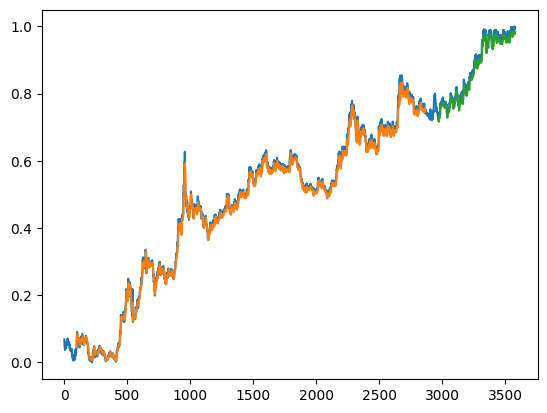

In [76]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
